In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
import ee
import time
import matplotlib.pyplot as plt
import sklearn
import scipy
from pylab import *
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
import warnings
warnings.filterwarnings("ignore")

ee.Initialize()

# def quadrant(df, x, y, xx = 'VV_db', yy = 'VV_db2'):
#     mean_y = df[yy].median()
#     mean_x = df[xx].median()
#     if (x > mean_x and y > mean_y): Q = 2
#     elif (x < mean_x and y > mean_y): Q = 1
#     elif (x < mean_x and y < mean_y): Q = 4
#     elif (x > mean_x and y < mean_y): Q = 3
#     elif (x == mean_x and y > mean_y): Q = 8
#     elif (x == mean_x and y < mean_y): Q = 7
#     elif (y == mean_y and x < mean_x): Q = 6
#     elif (y == mean_y and x > mean_x): Q = 5
#     else: Q = 0
#     return Q

In [19]:
def p2r(point, area_size = 100, field_size = 20):
    dist_lat = abs(area_size / 110.540)/1000
    dist_lon = abs(area_size / (111.320 * np.cos(point[0])))/1000
    area = {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {},"geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    dist_lat = abs(field_size / 110.540)/1000
    dist_lon = abs(field_size / (111.320 * np.cos(point[0])))/1000 
    soccer={"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2,point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_soccer = soccer['features'][0]['geometry']['coordinates']
    aoi_soccer = ee.Geometry.Polygon(coords_soccer)
    return(aoi_area, aoi_soccer)

def SigmaVV(date_start, date_stop, area, patch, dist, instrumentMode = 'IW', band2 = 'VV'):
    patch = patch.buffer(dist)
    im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # Select the image collection from the Google Earth Engine
                .filterBounds(area) # Limit the area
                .filterDate(ee.Date(date_start),ee.Date(date_stop)) # Select specific dates
                .filter(ee.Filter.eq('instrumentMode', instrumentMode)) # Select instrument (IW)
                .sort('system:time_start') # Sort the results by dates
                .select([band2, 'angle'])
                  ) # Select only the wanted band
    
    acq_times = im_coll.aggregate_array('system:time_start').getInfo() # Retrieve the list of dates
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times] # Change them to wanted format
    im_list = im_coll.toList(im_coll.size()) # Put the image collection to list
    
    SigmaVV_list = ee.List([])
    SigmaVV_list_VAR = ee.List([])
    
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(ee.Reducer.median(), patch) # Get the median value of the field
        return ee.List(list).add(local_image) # Add value to list
    
    def reduce_dataset_region_VAR(image, list):
        local_image = image.select(band2).reduceRegion(ee.Reducer.variance(), patch) # Get the median value of the field
        return ee.List(list).add(local_image) # Add value to list
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, SigmaVV_list)
    reduced_dataset_VAR = im_coll.iterate(reduce_dataset_region_VAR, SigmaVV_list_VAR)

    reduced_dataset_dict = reduced_dataset.getInfo()
    reduced_dataset_dict_VAR = reduced_dataset_VAR.getInfo()
    
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2, 'angle'])
    df2 = pd.DataFrame(reduced_dataset_dict_VAR)
    df1['Var_VV'] = df2.values
    df1 = df1.dropna()
    df1.index = pd.to_datetime(df1.index)
    df1 = df1.groupby(df1.index, as_index=True).mean()
    df1['VV_db'] = 10 * np.log10(df1['VV'])
    df1['VV_var_db'] = 10 * np.log10(df1['Var_VV'])
    df1 = df1[['angle', 'VV_db', 'VV_var_db']]
    return df1

def rain(date_start, date_stop, area, patch):
    band2 = 'precipitationCal'
    im_coll = dataset = ee.ImageCollection("NASA/GPM_L3/IMERG_V06")\
                        .filterBounds(area)\
                        .filterDate(ee.Date(date_start),ee.Date(date_stop))\
                        .select(band2)

    acq_times = im_coll.aggregate_array('system:time_start').getInfo()
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
    im_list = im_coll.toList(im_coll.size())
    
    variable_list = ee.List([])
   
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, variable_list)
    
    reduced_dataset_dict = reduced_dataset.getInfo()
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2]).dropna()
    df1.index = pd.to_datetime(df1.index)
    GPM_r = df1.resample('D').mean() * 24
    GPM_r.columns = ['GPM']
    return GPM_r

def merge_rain_sigma(sigma, rainIMERG):
    rescale = sigma.index[1] - sigma.index[0]
    index0 = sigma.index[0]
    index1 = sigma.index[1]
    dt = float(str(rescale).split()[0])
    if sigma.index[1] - sigma.index[0] == pd.to_timedelta('1 days 00:00:00'):
        sigma['VV_db2'] = sigma['VV_db'].shift(-2)
        sigma['VV_var_db2'] = sigma['VV_var_db'].shift(-2)
    else:
        sigma['VV_db2'] = sigma['VV_db'].shift(-1)
        sigma['VV_var_db2'] = sigma['VV_var_db'].shift(-1)
    sigma = sigma.dropna()
    
    merged_df = sigma.copy()
    if dt == 6:
        merged_df['GPM'] = rainIMERG.loc[index0:].resample('6D').sum()
    else:
        precA = rainIMERG.loc[index0:].resample('6D').sum()
        precB = rainIMERG.loc[index1:].resample('6D').sum()
        p6d = precA.append(precB)
        p6d = p6d.sort_index(ascending=True)
        merged_df['GPM'] = p6d
    merged_df = merged_df[['angle', 'VV_db', 'VV_db2', 'VV_var_db', 'VV_var_db2', 'GPM']]
    return merged_df

def plot_date(Date, rain_no_rain = True):
    for_plot = ghana_monthly[(ghana_monthly.index == Date)]

    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'

    shpfilename = shapereader.natural_earth(resolution, category, name)
    df = geopandas.read_file(shpfilename)
    poly = [df.loc[df['ADMIN'] == 'Ghana']['geometry'].values[0]]

    stamen_terrain = cimgt.Stamen('terrain-background')
    ll_proj = ccrs.PlateCarree()

    cmap = 'coolwarm_r'
    cmap_ = cm.get_cmap(cmap, 2)
    rgbs = []
    for i in range(cmap_.N):
        rgb = cmap_(i)[:3]
        rgbs.append(matplotlib.colors.rgb2hex(rgb))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ll_proj)
    ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')
    if rain_no_rain:
        im = ax.scatter(for_plot['Lon'], for_plot['Lat'], marker = 'p', cmap = cmap, c = for_plot['Rain/No Rain'], s = 60, zorder = 100, vmin = 0, vmax = 1)
        plt.scatter(0, 0, c = '{}'.format(rgbs[-1]), label = 'rain')
        plt.scatter(0, 0, c  = '{}'.format(rgbs[0]), label = 'no rain')
    else:
        im = ax.scatter(for_plot['Lon'], for_plot['Lat'], marker = 'p', cmap = cmap, c = for_plot['Estimated rainfall'], s = 60, zorder = 100)
    
    pad1 = 1
    exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
    ax.set_extent(exts, crs=ll_proj)
    gl = ax.gridlines(draw_labels=True, color = 'black', ls = '--', alpha = 0.3)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    plt.title('{} - {}'.format(((str(for_plot.index.min())).split()[0]), (str(for_plot.index.min() + pd.to_timedelta('6 days 00:00:00')).split()[0])))
    if rain_no_rain:
#         plt.colorbar(im, ax=ax)
        plt.legend()
    else:
        plt.colorbar(im, ax=ax)
    plt.ylim(4, 12);

a1 = [1.1240, 6.1259]
a2 = [0.4630, 7.4248]
a3 = [0.3963, 6.5684]
a4 = [0.1303, 6.0971]
a5 = [0.0509, 8.8628]
a6 = [-0.0128, 8.5515]
a7 = [0.0607, 8.7934]
a8 = [-0.0122, 9.0613]
a9 = [-0.1376, 6.3988]
a10 = [-0.1765, 5.6611]
a11 = [-0.2168, 5.7573]
a12 = [-0.4657, 5.4400]
a13 = [-1.0370, 6.6013]
a14 = [-1.0419, 6.6068]
a15 = [-1.2266, 6.6165]
a16 = [-1.3572, 6.2203]
a17 = [-1.5237, 6.8191]
a18 = [-1.5917, 6.7170]
a19 = [-1.7767, 9.2889]
a20 = [-2.1023, 7.7594]
a21 = [-2.1025, 7.7549]
a22 = [-2.6411, 5.1608]
a23 = [-2.4308, 9.4909]
a24 = [-2.5112, 10.4751]
a25 = [-2.6421, 5.1623]
a26 = [-2.8049, 7.2168]
a27 = [-2.8116, 6.3134]
a28 = [-2.8254, 6.3459]
a29 = [-3.0960, 6.6653]
a30 = [-2.8200, 5.8279]
a31 = [-2.0988, 7.1889]
a32 = [-1.4817, 6.8147]
a33 = [-2.2998, 6.4751]
a34 = [1.1241, 6.1258]
a35 = [0.3142, 5.9863]
a36 = [-0.9990, 6.1270]
a37 = [0.7875, 7.7345]
a38 = [-0.1673, 6.9981]
a39 = [-0.0693, 10.8298]
a40 = [-1.8624, 9.2232]
a41 = [-1.3236, 6.1953]
a42 = [-1.3987, 6.2352]
a43 = [-0.9404, 10.8247]
a44 = [-1.7454, 7.9535]
a45 = [-1.7454, 7.9535]
a46 = [-0.0893, 8.2984]
a47 = [-0.4107, 7.7891]
a48 = [-2.3009, 6.4632]
a49 = [-2.4253, 9.2646]

stations_df = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, 
            a13, a14, a15, a16, a18, a19, a20, a21, a22, a23, a24,
           a25, a26, a27, a28, a29, a30, a31, a32, a33, a34, a35, a36,
           a37, a38, a39, a40, a41, a42, a42, a43, a44, a45, a46, a47, a48, a49]

In [3]:
all_data = pd.read_csv('training_data.csv', index_col = 0, parse_dates = True)
# Q = []
# for i in range(len(all_data)):
#     Q.append(quadrant(all_data, all_data['VV_db'][i], all_data['VV_db2'][i]))
# all_data['Q'] = Q

all_data

,angle,VV_db,VV_db2,VV_var_db,VV_var_db2,GPM,P6d
2020-01-06,36.694851,-17.268671,-18.514106,-46.914630,-43.748117,1.643951,0.102
2020-01-12,36.693722,-18.514106,-20.055478,-43.748117,-43.455920,1.979395,0.476
2020-01-12,36.693722,-18.514106,-20.055478,-43.748117,-43.455920,1.979395,0.476
2020-01-18,36.694202,-20.055478,-16.758137,-43.455920,-47.026806,0.193618,0.272
2020-01-18,36.694202,-20.055478,-16.758137,-43.455920,-47.026806,0.193618,0.272
...,...,...,...,...,...,...,...
2020-12-05,41.995583,-10.524538,-11.249500,-34.887105,-35.694236,2.292884,70.388
2020-12-11,42.003204,-11.249500,-13.816053,-35.694236,-35.753749,8.433577,28.578
2020-12-11,42.003204,-11.249500,-13.816053,-35.694236,-35.753749,8.433577,28.578
2020-12-17,41.996529,-13.816053,-9.294661,-35.753749,-31.186179,0.276911,5.816


In [4]:
threshold = 5

X = all_data[['angle', 'VV_db', 'VV_db2', 'VV_var_db', 'VV_var_db2', 'GPM']].values
y = all_data[['P6d']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = True)

GPM_class = np.where(X_test[:, -1] >= 5, 1, 0)
y_train_class = np.where(y_train >= 5, 1, 0)
y_test_class = np.where(y_test >= 5, 1, 0)

In [5]:
level0 = list()
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('rf', RandomForestClassifier(n_estimators=100)))
level0.append(('NN', (MLPClassifier(hidden_layer_sizes=(10,), activation = 'logistic', max_iter=1000, alpha=0.0001,
                 solver='adam', verbose=False,  tol=0.000000001, warm_start = True))))
level1 = LogisticRegression()
classifier = StackingClassifier(estimators=level0, final_estimator=level1, passthrough = True, cv=10)
classifier.fit(X_train, y_train_class)

y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)

print('Classification Score of Sigma2Rain: {}, Classification score of GPM {}'.format(np.round(mt.f1_score(y_pred, y_test_class), 3), np.round(mt.f1_score(y_pred, GPM_class), 3)))

Classification Score of Sigma2Rain: 0.924, Classification score of GPM 0.816


In [6]:
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
level0.append(('rf', RandomForestRegressor(n_estimators=100)))
level1 = MLPRegressor(hidden_layer_sizes=(10,), activation = 'logistic', max_iter=1000, alpha=0.0001,
                 solver='adam', verbose=False,  tol=0.000000001, warm_start = True)
regressor = StackingRegressor(estimators=level0, final_estimator=level1, passthrough = True, cv=10)
regressor.fit(X_train, y_train)

y_pred_reg = regressor.predict(X_test)

corr, _ = scipy.stats.pearsonr(y_pred_reg, y_test)
corr_gpm, _ = scipy.stats.pearsonr(X_test[:, -1], y_test)

print('Pearson correlation of Sigma2Rain: {}, Pearson correlation of GPM {}'.format(np.round(corr, 3), np.round(corr_gpm, 3)))

Pearson correlation of Sigma2Rain: 0.88, Pearson correlation of GPM 0.643


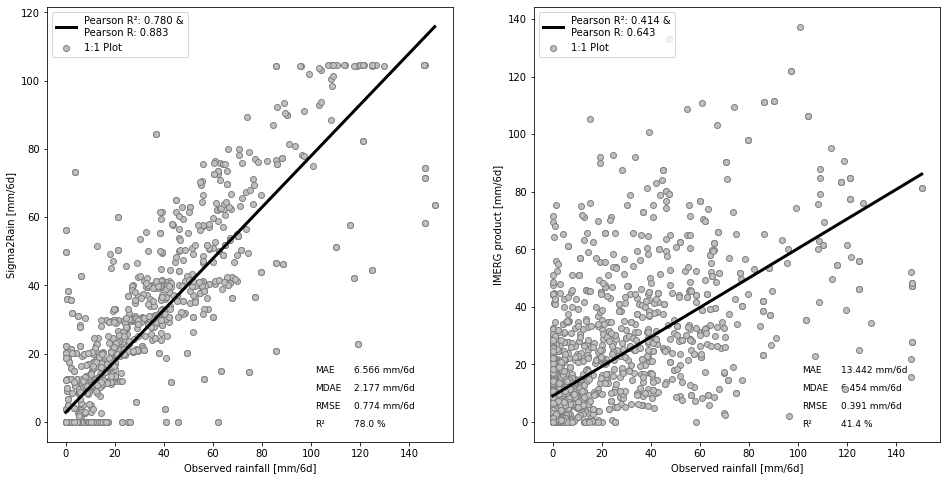

In [7]:
results = pd.DataFrame(y_pred, columns = ['Rain/No Rain'])
results['Probability of Rain'] = np.round(y_prob[:, 1], 2)
results['Estimated rainfall'] = y_pred_reg
results['Estimated rainfall'][results['Probability of Rain'] < 0.5] = 0
results['GPM'] = X_test[:, -1]
results['Observed rainfall'] = y_test
results[['GPM', 'Observed rainfall', 'Rain/No Rain', 'Probability of Rain', 'Estimated rainfall']].round(2)

O = results['Observed rainfall']
P = results['Estimated rainfall']

mae = sklearn.metrics.mean_absolute_error(O, P) # Mean absolute error
mdae = sklearn.metrics.median_absolute_error(O, P) # Median absolute error
RSq = sklearn.metrics.r2_score(O, P) # Rsquared score
rmse = sklearn.metrics.mean_squared_error(O, P, squared=False) # RMSE values
R2 = scipy.stats.linregress(O, P)[2]**2 # R2 score
metrics = np.array([mae, mdae, RSq, rmse, R2])
# edgecolor='maroon', facecolors='firebrick'

plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
corr, _ = scipy.stats.pearsonr(O, P)
regmodel = LinearRegression()
regmodel.fit(O.values.reshape(-1,1), P)
rsq = regmodel.score(O.values.reshape(-1,1), P)
obs, pred = O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1))
plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
plt.xlabel('Observed rainfall [mm/6d]')
plt.ylabel('Sigma2Rain [mm/6d]')
stats = np.round(metrics, 3)
stats = pd.DataFrame(data = stats, index = ['MAE', 'MDAE', 'RMSE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
stats.loc['RSq'] = np.round((stats.loc['RSq']* 100) , 2)
stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']* 100) , 2) 
stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm/6d' )
stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
stats = stats2.append(stats3)
stats = stats.drop('RSq', 0) # Rsq is not working well on non linear
table = plt.table(cellText=stats.values, colWidths = [0.5] * len(stats.columns),
      rowLabels = stats.index, cellLoc = 'left', rowLoc = 'left', loc = 4, edges='open') # Adjust table size loc and allignment
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(.5, 1.5)
plt.legend([u'Pearson R\u00b2: {:.3f} &\nPearson R: {:.3f}'.format(corr**2, corr), '1:1 Plot', 'Observed - Predicted'], loc = 2)


P = results['GPM']
mae = sklearn.metrics.mean_absolute_error(O, P) # Mean absolute error
mdae = sklearn.metrics.median_absolute_error(O, P) # Median absolute error
RSq = sklearn.metrics.r2_score(O, P) # Rsquared score
rmse = sklearn.metrics.mean_squared_error(O, P, squared=False) # RMSE values
R2 = scipy.stats.linregress(O, P)[2]**2 # R2 score
metrics = np.array([mae, mdae, RSq, rmse, R2])

plt.subplot(1, 2, 2)
plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
corr, _ = scipy.stats.pearsonr(O, P)
regmodel = LinearRegression()
regmodel.fit(O.values.reshape(-1,1), P)
rsq = regmodel.score(O.values.reshape(-1,1), P)
obs, pred = O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1))
plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
plt.xlabel('Observed rainfall [mm/6d]')
plt.ylabel('IMERG product [mm/6d]')
stats = np.round(metrics, 3)
stats = pd.DataFrame(data = stats, index = ['MAE', 'MDAE', 'RMSE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
stats.loc['RSq'] = np.round((stats.loc['RSq']* 100) , 2)
stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']* 100) , 2) 
stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm/6d' )
stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
stats = stats2.append(stats3)
stats = stats.drop('RSq', 0) # Rsq is not working well on non linear
table = plt.table(cellText=stats.values, colWidths = [0.5] * len(stats.columns),
      rowLabels = stats.index, cellLoc = 'left', rowLoc = 'left', loc = 4, edges='open') # Adjust table size loc and allignment
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(.5, 1.5)
plt.legend([u'Pearson R\u00b2: {:.3f} &\nPearson R: {:.3f}'.format(corr**2, corr), '1:1 Plot', 'Observed - Predicted'], loc = 2)

In [8]:
date_start = '2021-08-01'
date_stop = '2021-09-01'

aoi_area, aoi_soccer = p2r(a23, area_size = 1000, field_size = 20)

sigma = SigmaVV(date_start, date_stop, aoi_area, aoi_soccer, 1)
rainIMERG = rain(date_start, date_stop, aoi_area, aoi_soccer)
rainfall_prediction = merge_rain_sigma(sigma, rainIMERG)

rainfall_prediction_class = rainfall_prediction.copy()

# rainfall_prediction_class['GPM'][rainfall_prediction_class['GPM'] < threshold] = 0
# rainfall_prediction_class['GPM'][rainfall_prediction_class['GPM'] > 0] = 1

y_pred = classifier.predict(rainfall_prediction_class.values)
y_prob = classifier.predict_proba(rainfall_prediction_class.values)

y_pred_reg = regressor.predict(rainfall_prediction.values)

results = pd.DataFrame(y_pred, columns = ['Rain/No Rain'])
results['Probability of Rain'] = np.round(y_prob[:, 1], 2)
results['Estimated rainfall'] = y_pred_reg
results['Estimated rainfall'][results['Probability of Rain'] < 0.5] = 0
results['GPM'] = np.round(rainfall_prediction['GPM'].values)
results[['GPM', 'Rain/No Rain', 'Probability of Rain', 'Estimated rainfall']].round(2)
results.index = rainfall_prediction.index
results

,Rain/No Rain,Probability of Rain,Estimated rainfall,GPM
2021-08-02,1,0.55,3.861984,50.0
2021-08-03,1,0.95,56.225590,62.0
2021-08-08,1,0.72,64.680146,61.0
2021-08-09,1,0.95,63.611026,49.0
2021-08-14,1,0.83,27.792164,13.0
2021-08-15,1,0.92,38.124613,15.0
2021-08-20,1,0.70,45.919295,75.0
2021-08-21,1,0.98,63.053743,76.0


In [9]:
ghana_monthly = pd.DataFrame()

date_start = '2021-07-01'
date_stop = '2021-09-01'

for i in tqdm(range(len(stations_df))):
    aoi_area, aoi_soccer = p2r(stations_df[i], area_size = 1000, field_size = 20)

    sigma = SigmaVV(date_start, date_stop, aoi_area, aoi_soccer, 1)
    rainIMERG = rain(date_start, date_stop, aoi_area, aoi_soccer)
    rainfall_prediction = merge_rain_sigma(sigma, rainIMERG)

    rainfall_prediction_class = rainfall_prediction.copy()
    y_pred = classifier.predict(rainfall_prediction_class.values)
    y_prob = classifier.predict_proba(rainfall_prediction_class.values)

    y_pred_reg = regressor.predict(rainfall_prediction.values)

    results = pd.DataFrame(y_pred, columns = ['Rain/No Rain'])
    results['Probability of Rain'] = np.round(y_prob[:, 1], 2)
    results['Estimated rainfall'] = y_pred_reg
    results['Estimated rainfall'][results['Probability of Rain'] < 0.5] = 0
    results['GPM'] = np.round(rainfall_prediction['GPM'].values)
    results[['GPM', 'Rain/No Rain', 'Probability of Rain', 'Estimated rainfall']].round(2)
    results.index = rainfall_prediction.index
    results['Lon'], results['Lat'] = stations_df[i]
    ghana_monthly = ghana_monthly.append(results)
    
av_dates = []
for i in range(len(np.unique(ghana_monthly.index))):
    av_dates.append(str(pd.to_datetime(np.unique(ghana_monthly.index)[i])).split()[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [13:48<00:00, 16.91s/it]


In [20]:
interact(plot_date, Date = widgets.Dropdown(options=av_dates), rain_no_rain = True);

interactive(children=(Dropdown(description='Date', options=('2021-07-03', '2021-07-04', '2021-07-05', '2021-07…